<a href="https://colab.research.google.com/github/Miranics/ML_JACKS/blob/main/Advanced_CNN_for_Malaria_Cell_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

miraclenanenmbanaade_malaria_cell_images_dataset_path = kagglehub.dataset_download('miraclenanenmbanaade/malaria-cell-images-dataset')

print('Data source import complete.')


# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

# Advanced CNN for Malaria Cell Classification

This notebook implements an advanced convolutional neural network and runs a sequence of controlled experiments to evaluate architectural and training choices.


In [ ]:
import os
import shutil
from PIL import Image

DATASET_PATH = "/kaggle/input/malaria-cell-images-dataset"
WORK_DIR = "/kaggle/working/malaria_data"

if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)

shutil.copytree(DATASET_PATH, WORK_DIR)

print("Copied dataset to:", WORK_DIR)
print("Folders:", os.listdir(WORK_DIR))

def clean_images(folder):
    valid = 0
    removed = 0

    for root, _, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)
            try:
                img = Image.open(path)
                img.verify()
                valid += 1
            except:
                removed += 1
                os.remove(path)

    return valid, removed

valid_count, removed_count = clean_images(WORK_DIR)

print("Valid images:", valid_count)
print("Removed:", removed_count)

FINAL_DATA_PATH = WORK_DIR
print("Final training path:", FINAL_DATA_PATH)


Copied dataset to: /kaggle/working/malaria_data
Folders: ['Parasitized', 'Uninfected']
Valid images: 27558
Removed: 2
Final training path: /kaggle/working/malaria_data


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score
)

tf.random.set_seed(42)
np.random.seed(42)


## Global Configuration

Define dataset paths, image size, batch size, and random seed.


In [ ]:
DATA_DIR = "/kaggle/working/malaria_data"

IMG_SIZE = 128
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

EXPERIMENT_DIR = "/kaggle/working/advanced_cnn_results"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)


## Dataset Loading

Load the malaria images into training and validation datasets.


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)
print("Number of classes:", NUM_CLASSES)


Found 27558 files belonging to 2 classes.
Using 22047 files for training.


I0000 00:00:1770591007.946962      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Classes: ['Parasitized', 'Uninfected']
Number of classes: 2


## Dataset Optimization

Cache, shuffle, and prefetch the datasets for efficient GPU training.


In [ ]:
train_ds = (
    train_ds
    .cache()
    .shuffle(1000, seed=SEED)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


## Advanced CNN Architecture

Define a deeper CNN with batch normalization, dropout, and data augmentation.

In [ ]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def build_advanced_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=2):

    model = models.Sequential([
        layers.Input(shape=input_shape),

        data_augmentation,

        layers.Rescaling(1./255),

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Flatten(),

        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation="softmax"),
    ])

    return model


model = build_advanced_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,522 (32.36 MB)

 Trainable params: 8,483,074 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Experiment 1 – Baseline Training of Advanced CNN

Train the model for up to 10 epochs with standard optimization.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 10

history_exp1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


E0000 00:00:1770591059.925268      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1770591071.767911     129 cuda_dnn.cc:529] Loaded cuDNN version 91002


689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6422 - loss: 0.8445 - val_accuracy: 0.6023 - val_loss: 1.7365
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7788 - loss: 0.4705 - val_accuracy: 0.8668 - val_loss: 0.3518
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8973 - loss: 0.2648 - val_accuracy: 0.7342 - val_loss: 0.6900
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9270 - loss: 0.2026 - val_accuracy: 0.8372 - val_loss: 0.4254
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9349 - loss: 0.1970 - val_accuracy: 0.6815 - val_loss: 1.4239
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9422 - loss: 0.1741 - val_accuracy: 0.7583 - val_loss: 0.7810
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9441 - loss: 0.1685 - val_accuracy: 0.7743 - val_loss: 0.7024
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9471 - loss: 0.1646 - val_accurac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

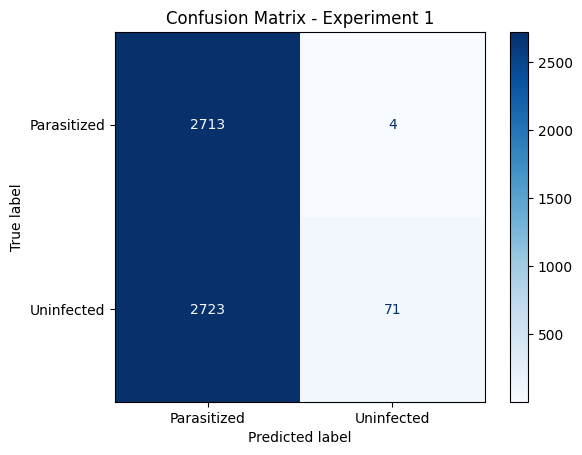

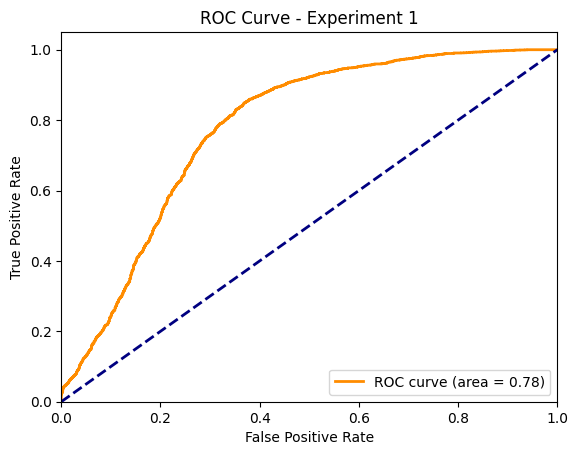

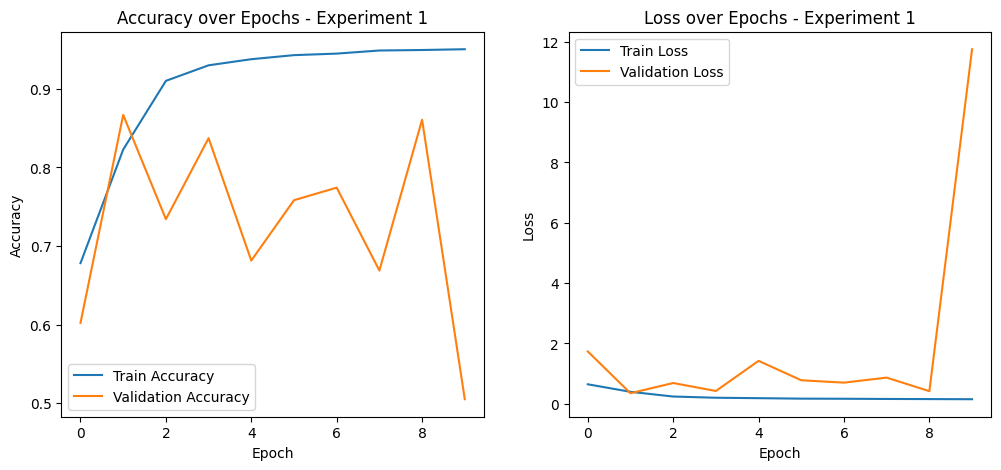

In [ ]:
## Experiment 1 Visualization
# Visualize training performance, confusion matrix, and ROC/AUC curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Save model and history
model_exp1 = model
history_exp1 = history_exp1  # Already defined from training

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp1.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs >= 0.5).astype(int)

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Parasitized", "Uninfected"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Experiment 1")
plt.show()

# ---- ROC / AUC ----
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Experiment 1')
plt.legend(loc="lower right")
plt.show()

# ---- Training / Validation Accuracy & Loss ----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_exp1.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs - Experiment 1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp1.history['loss'], label='Train Loss')
plt.plot(history_exp1.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs - Experiment 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Experiment 2 - Advanced CNN with deeper layers

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model_exp2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
EPOCHS = 10
history_exp2 = model_exp2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1770593829.332800     129 service.cc:152] XLA service 0x7be4bc119210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770593829.332850     129 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5376 - loss: 4.7538 

I0000 00:00:1770593836.435998     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.6496 - loss: 0.9816 - val_accuracy: 0.5580 - val_loss: 1.3885
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8985 - loss: 0.2737 - val_accuracy: 0.5736 - val_loss: 3.0254
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9415 - loss: 0.1783 - val_accuracy: 0.5765 - val_loss: 2.7221
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9477 - loss: 0.1537 - val_accuracy: 0.6376 - val_loss: 2.0041
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9506 - loss: 0.1455 - val_accuracy: 0.6162 - val_loss: 2.5620
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9570 - loss: 0.1297 - val_accuracy: 0.7376 - val_loss: 0.7856
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9589 - loss: 0.1184 - val_accuracy: 0.7055 - val_loss: 1.0291
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9641 - loss: 0.1075 - val_accurac

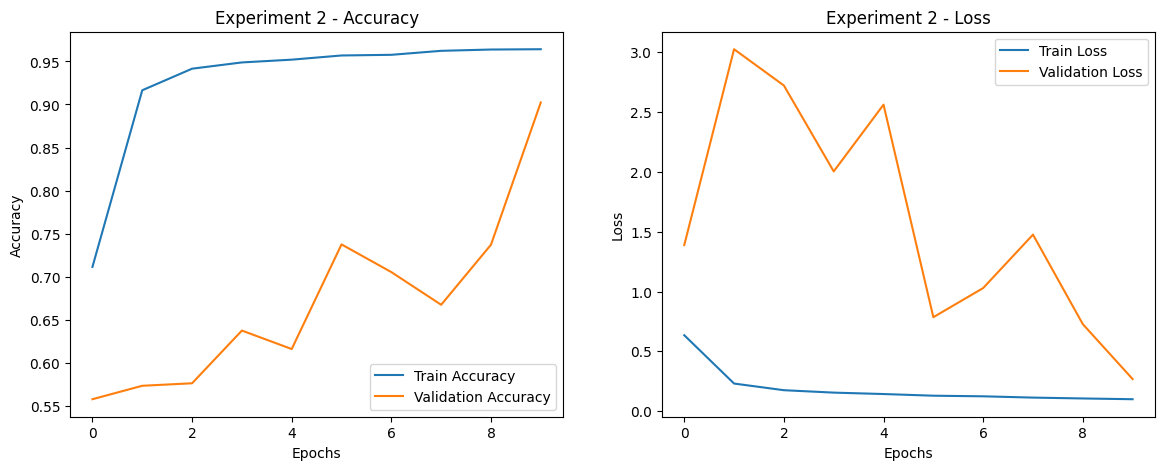

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

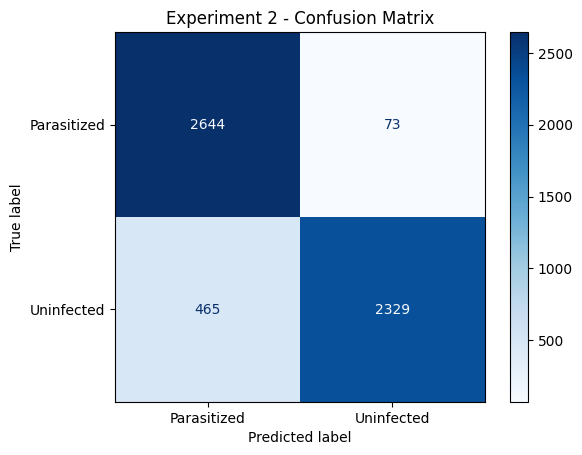

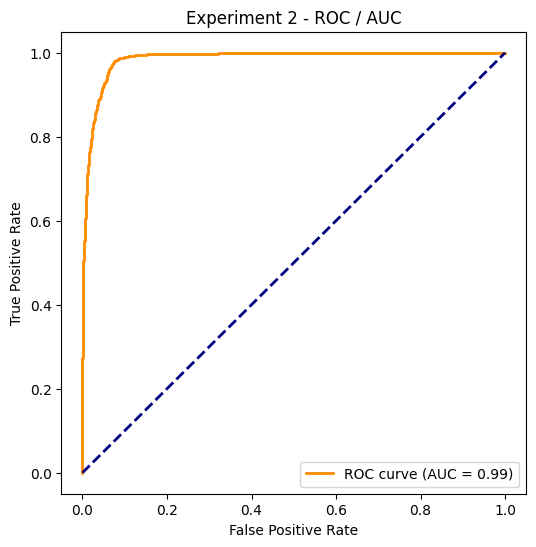

In [ ]:
## Experiment 2 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp2.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp2.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 2 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp2.history['loss'], label='Train Loss')
plt.plot(history_exp2.history['val_loss'], label='Validation Loss')
plt.title("Experiment 2 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp2.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 2 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 2 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 3 - Advanced CNN with Additional Convolutional Layers

This experiment explores a deeper CNN architecture with more convolutional layers and dropout for regularization to improve classification performance.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Experiment 3 model
model_exp3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 10
history_exp3 = model_exp3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.6134 - loss: 0.9292 - val_accuracy: 0.6587 - val_loss: 0.6374
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7036 - loss: 0.5674 - val_accuracy: 0.7177 - val_loss: 3.4426
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9161 - loss: 0.2284 - val_accuracy: 0.8176 - val_loss: 1.3442
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9427 - loss: 0.1750 - val_accuracy: 0.9193 - val_loss: 0.2252
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9501 - loss: 0.1551 - val_accuracy: 0.6309 - val_loss: 1.7368
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9523 - loss: 0.1449 - val_accuracy: 0.7503 - val_loss: 1.6876
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9559 - loss: 0.1319 - val_accuracy: 0.6217 - val_loss: 4.8421
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9566 - loss: 0.1308 - val_accurac

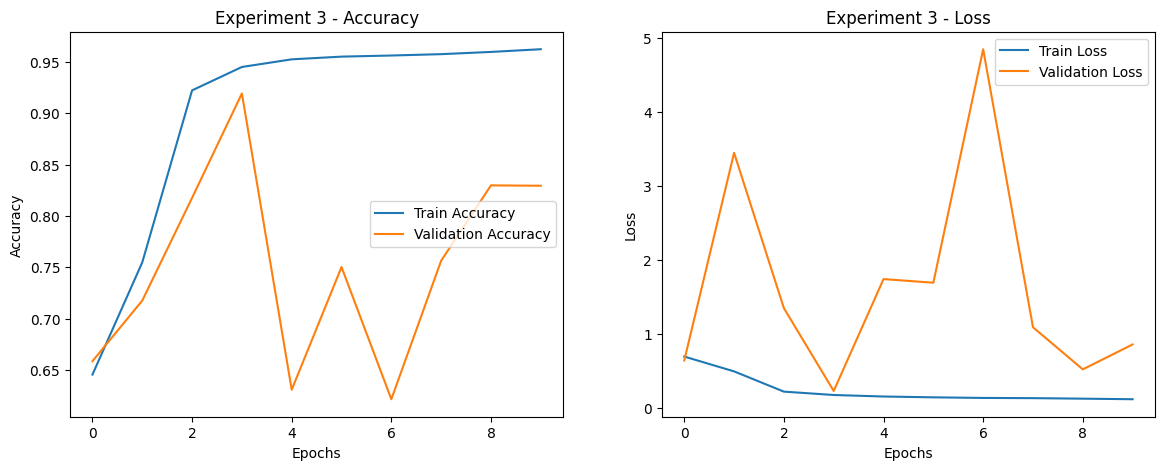

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

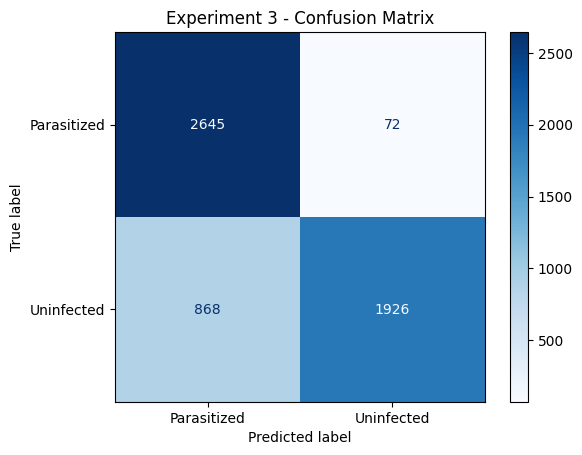

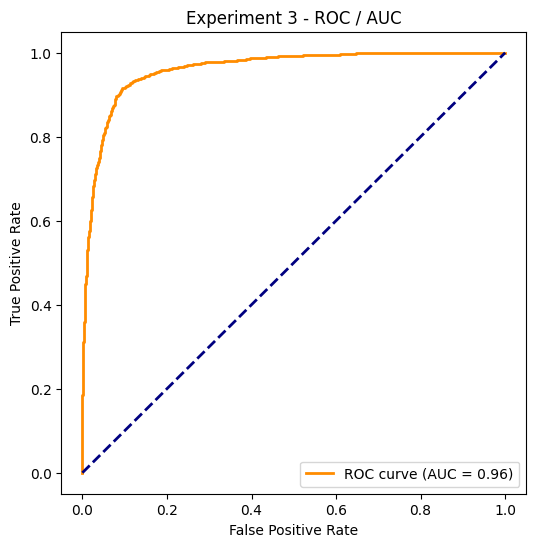

In [ ]:
## Experiment 3 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp3.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp3.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 3 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp3.history['loss'], label='Train Loss')
plt.plot(history_exp3.history['val_loss'], label='Validation Loss')
plt.title("Experiment 3 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp3.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 3 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 3 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 4 - Advanced CNN with Increased Dropout and Regularization

This experiment investigates adding higher dropout rates and batch normalization to reduce overfitting and improve generalization on the validation set.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Experiment 4 model
model_exp4 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 10
history_exp4 = model_exp4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 0.6010 - loss: 0.9064 - val_accuracy: 0.5485 - val_loss: 1.0241
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7314 - loss: 0.5449 - val_accuracy: 0.7207 - val_loss: 0.6010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.8972 - loss: 0.2731 - val_accuracy: 0.9196 - val_loss: 0.2454
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9350 - loss: 0.1782 - val_accuracy: 0.7039 - val_loss: 3.1199
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9475 - loss: 0.1548 - val_accuracy: 0.5306 - val_loss: 20.7666
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9543 - loss: 0.1372 - val_accuracy: 0.9336 - val_loss: 0.2290
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9560 - loss: 0.1303 - val_accuracy: 0.8969 - val_loss: 0.3201
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9608 - loss: 0.1265 - val_accura

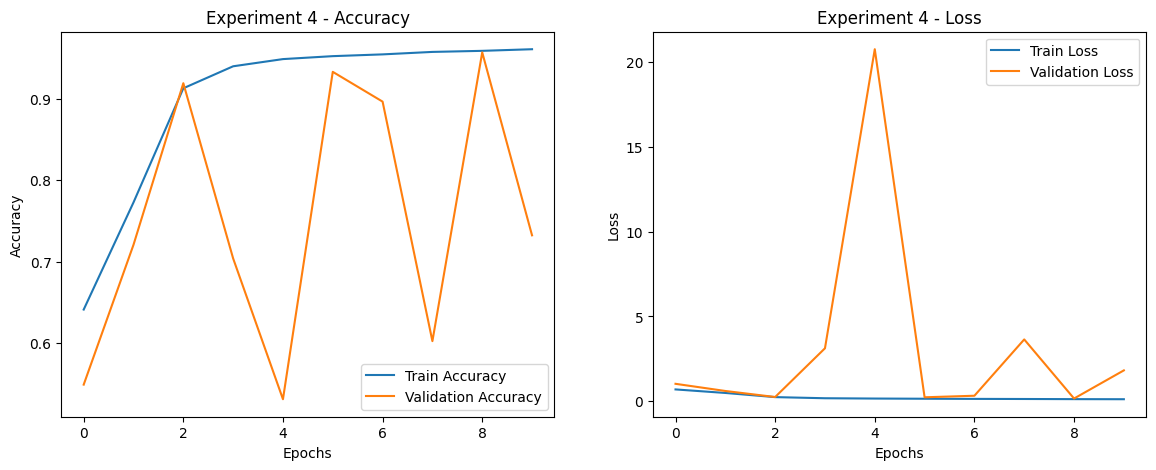

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

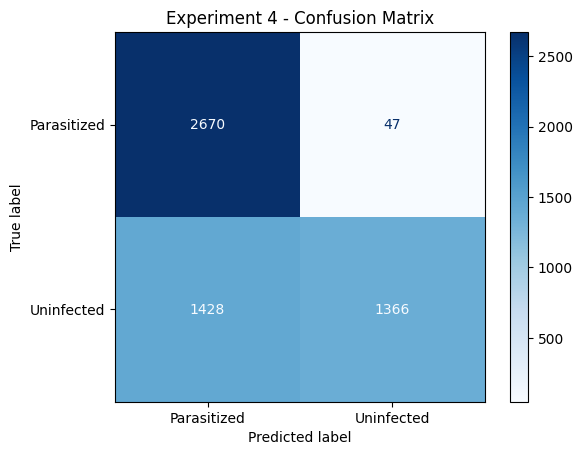

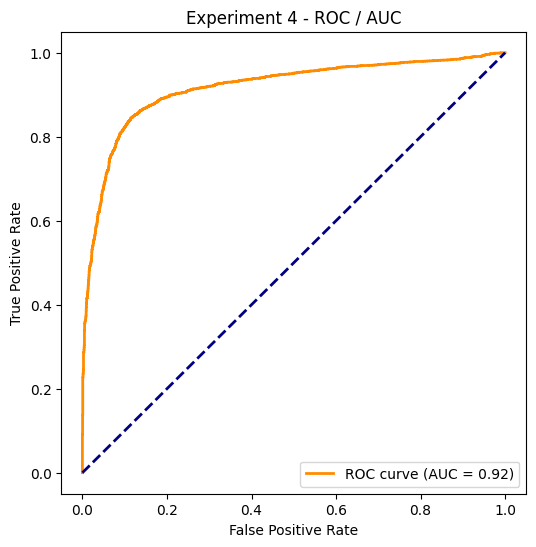

In [ ]:
## Experiment 4 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp4.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp4.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 4 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp4.history['loss'], label='Train Loss')
plt.plot(history_exp4.history['val_loss'], label='Validation Loss')
plt.title("Experiment 4 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp4.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 4 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 4 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 5 - Advanced CNN with Increased Filter Sizes

This experiment investigates using larger convolutional filters to capture more complex spatial features from the images.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Experiment 5 model
model_exp5 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.Conv2D(64, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (5,5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 10
history_exp5 = model_exp5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.6307 - loss: 1.3223 - val_accuracy: 0.6137 - val_loss: 1.7528
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.8605 - loss: 0.3409 - val_accuracy: 0.9407 - val_loss: 0.2480
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9392 - loss: 0.1762 - val_accuracy: 0.7565 - val_loss: 0.5109
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9494 - loss: 0.1510 - val_accuracy: 0.6707 - val_loss: 0.6478
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9554 - loss: 0.1327 - val_accuracy: 0.8265 - val_loss: 0.3554
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9517 - loss: 0.1386 - val_accuracy: 0.9191 - val_loss: 0.2261
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9577 - loss: 0.1230 - val_accuracy: 0.6901 - val_loss: 1.5307
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9591 - loss: 0.1195 - val_accurac

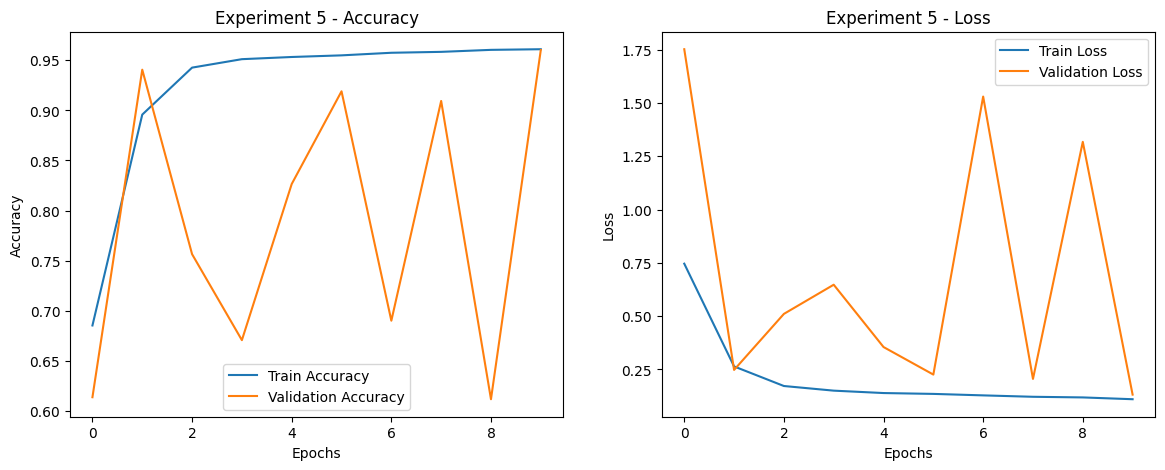

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

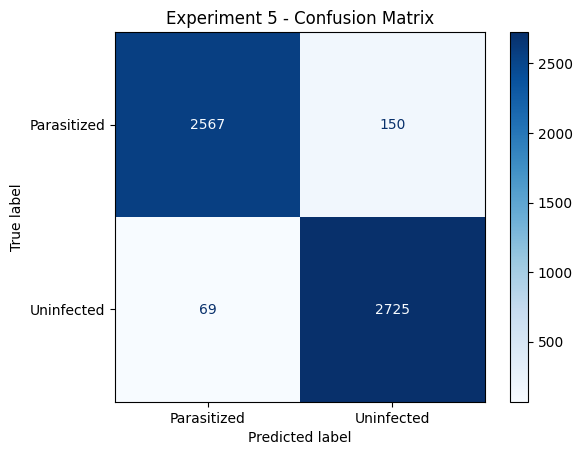

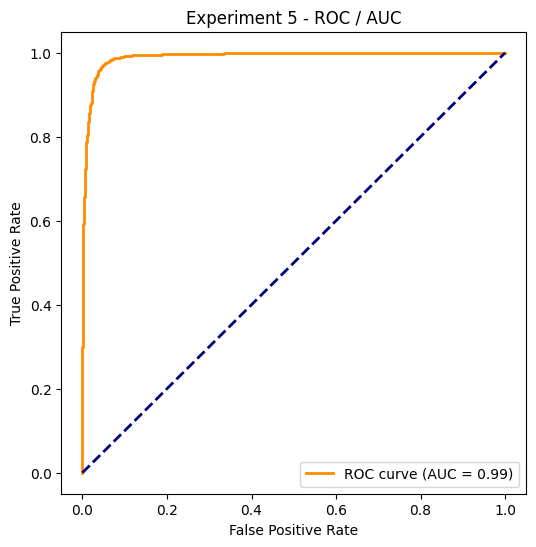

In [ ]:
## Experiment 5 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp5.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp5.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 5 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp5.history['loss'], label='Train Loss')
plt.plot(history_exp5.history['val_loss'], label='Validation Loss')
plt.title("Experiment 5 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp5.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 5 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 5 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 6 - Advanced CNN with Depthwise Convolutions

This experiment explores depthwise separable convolutions to reduce parameters while maintaining feature extraction capability.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Experiment 6 model
model_exp6 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.SeparableConv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 10
history_exp6 = model_exp6.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.6115 - loss: 0.9139 - val_accuracy: 0.5215 - val_loss: 1.3883
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.6953 - loss: 0.5883 - val_accuracy: 0.6017 - val_loss: 1.3348
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.7911 - loss: 0.4558 - val_accuracy: 0.8322 - val_loss: 0.7616
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9146 - loss: 0.2279 - val_accuracy: 0.9133 - val_loss: 0.3363
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9348 - loss: 0.1844 - val_accuracy: 0.9281 - val_loss: 0.2835
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9430 - loss: 0.1656 - val_accuracy: 0.9287 - val_loss: 0.3059
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9513 - loss: 0.1471 - val_accuracy: 0.9316 - val_loss: 0.2415
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9536 - loss: 0.1388 - val_accurac

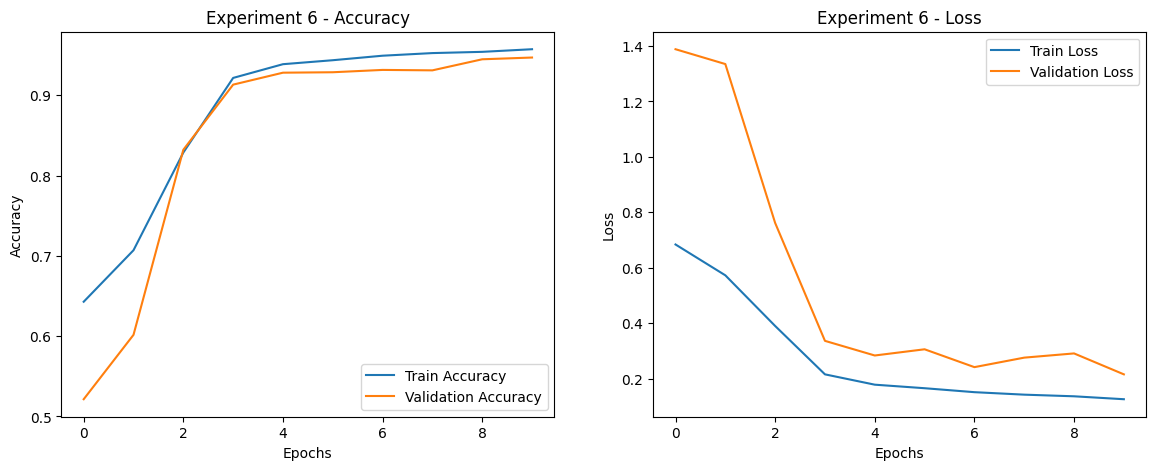

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

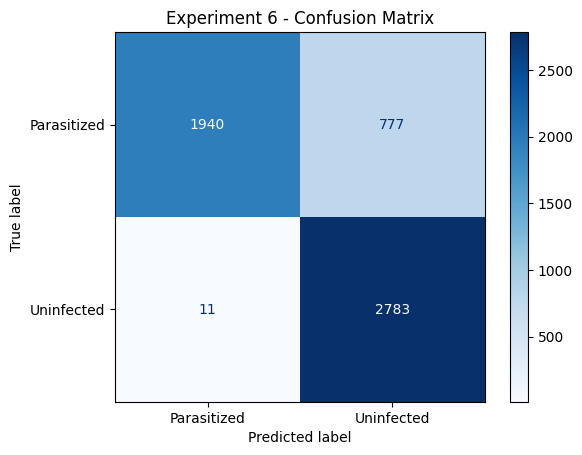

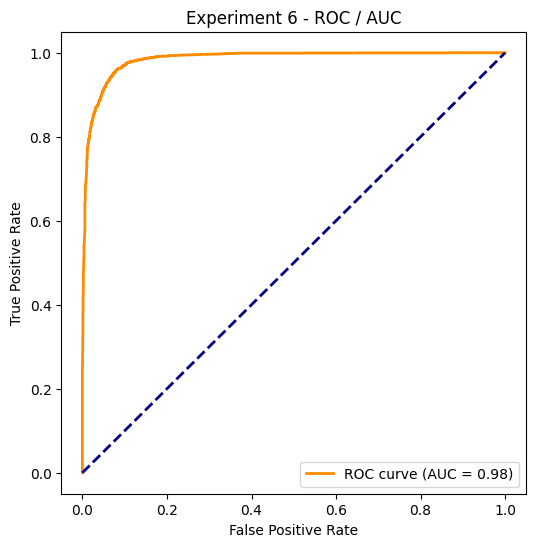

In [ ]:
## Experiment 6 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp6.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp6.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 6 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp6.history['loss'], label='Train Loss')
plt.plot(history_exp6.history['val_loss'], label='Validation Loss')
plt.title("Experiment 6 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp6.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 6 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 6 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 7 - Advanced CNN with Increased Filters

This experiment increases the number of filters in each convolutional layer to capture more complex features.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Experiment 7 model
model_exp7 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model_exp7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 10
history_exp7 = model_exp7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.6504 - loss: 1.3842 - val_accuracy: 0.8138 - val_loss: 1.1679
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9242 - loss: 0.2194 - val_accuracy: 0.8946 - val_loss: 0.5244
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9501 - loss: 0.1614 - val_accuracy: 0.9521 - val_loss: 0.2781
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9526 - loss: 0.1445 - val_accuracy: 0.9091 - val_loss: 0.2039
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9545 - loss: 0.1381 - val_accuracy: 0.9604 - val_loss: 0.1130
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9561 - loss: 0.1396 - val_accuracy: 0.9443 - val_loss: 0.1859
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9590 - loss: 0.1239 - val_accuracy: 0.9247 - val_loss: 0.1937
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9606 - loss: 0.1242 - val_accurac

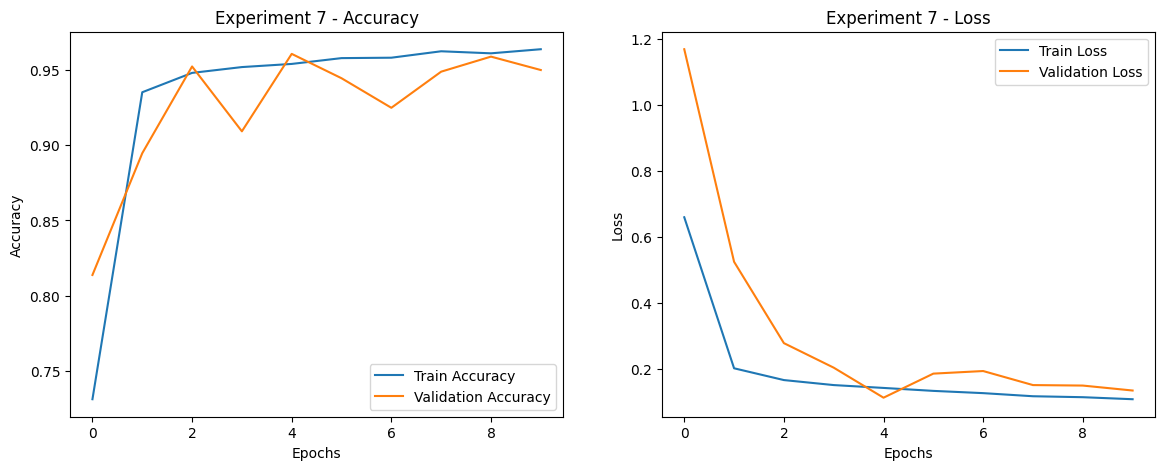

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

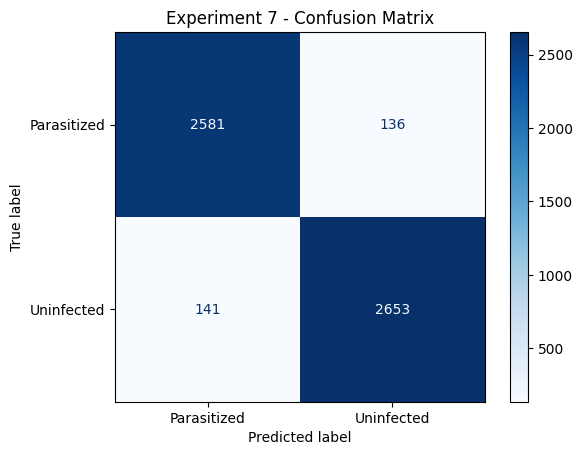

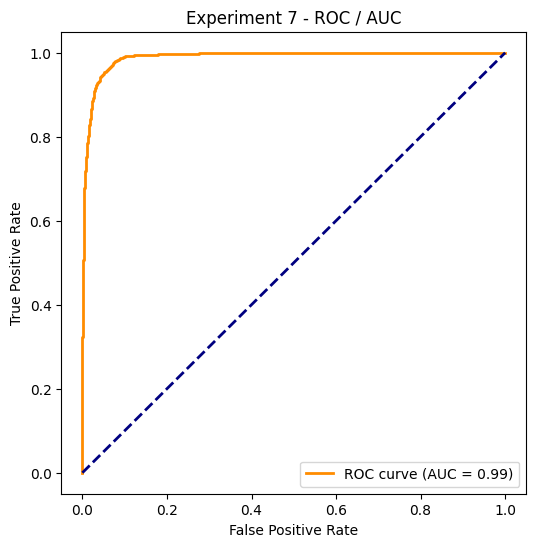

In [ ]:
## Experiment 7 Visualization - Accuracy/Loss, Confusion Matrix, ROC/AUC

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plot training and validation accuracy/loss
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_exp7.history['accuracy'], label='Train Accuracy')
plt.plot(history_exp7.history['val_accuracy'], label='Validation Accuracy')
plt.title("Experiment 7 - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp7.history['loss'], label='Train Loss')
plt.plot(history_exp7.history['val_loss'], label='Validation Loss')
plt.title("Experiment 7 - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Prepare true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp7.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds[:,1])  # probability of class 1

y_pred = np.argmax(np.array([ [1-p, p] for p in y_pred_probs ]), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized','Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Experiment 7 - Confusion Matrix")
plt.show()

# ROC / AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Experiment 7 - ROC / AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## Experiment 8 - Advanced CNN with Residual Connections

This experiment introduces simple residual connections to improve gradient flow and model stability.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# --- Residual block definition with shape projection ---
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    return x

# --- Model definition ---
inputs = Input(shape=(128,128,3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model_exp8 = Model(inputs, outputs)

# --- Compile the model ---
model_exp8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Train the model ---
EPOCHS = 10
history_exp8 = model_exp8.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.6090 - loss: 1.0475 - val_accuracy: 0.6306 - val_loss: 0.6849
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.8435 - loss: 0.3759 - val_accuracy: 0.9356 - val_loss: 0.1885
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9363 - loss: 0.2002 - val_accuracy: 0.9443 - val_loss: 0.1643
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9438 - loss: 0.1824 - val_accuracy: 0.9376 - val_loss: 0.1739
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9411 - loss: 0.1776 - val_accuracy: 0.9439 - val_loss: 0.1660
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9513 - loss: 0.1646 - val_accuracy: 0.9499 - val_loss: 0.1496
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9480 - loss: 0.1598 - val_accuracy: 0.9588 - val_loss: 0.1255
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9537 - loss: 0.1487 - 

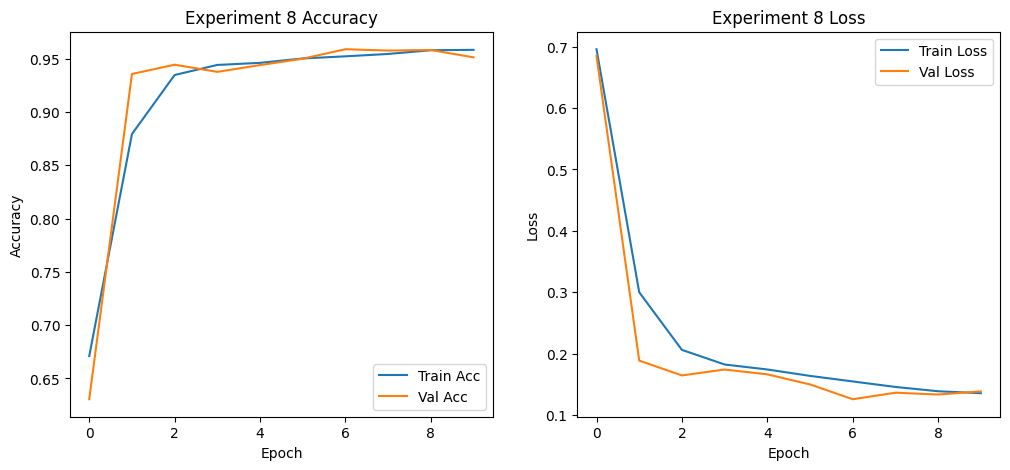

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

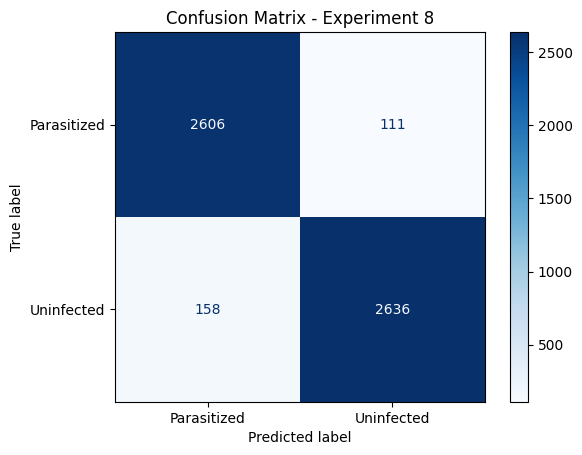

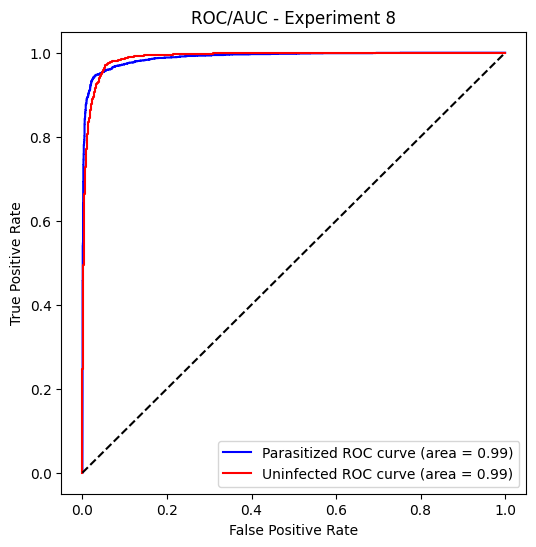

In [ ]:
# --- Visualization: Accuracy and Loss Curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_exp8.history['accuracy'], label='Train Acc')
plt.plot(history_exp8.history['val_accuracy'], label='Val Acc')
plt.title('Experiment 8 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_exp8.history['loss'], label='Train Loss')
plt.plot(history_exp8.history['val_loss'], label='Val Loss')
plt.title('Experiment 8 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Confusion Matrix and ROC/AUC ---
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    preds = model_exp8.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Parasitized', 'Uninfected'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Experiment 8")
plt.show()

# ROC/AUC
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=2)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], np.array(y_pred_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,6))
plt.plot(fpr[0], tpr[0], color='blue', label='Parasitized ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='red', label='Uninfected ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC/AUC - Experiment 8')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Summary Table: Collect metrics for all experiments

In [ ]:

# Collect predictions for all experiments

import numpy as np

# Dictionary to store true labels and predictions
y_true_dict = {}
y_pred_dict = {}

for i, model in enumerate([model_exp1, model_exp2, model_exp3, model_exp4,
                           model_exp5, model_exp6, model_exp7, model_exp8], start=1):
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    y_true_dict[f'y_true_exp{i}'] = np.array(y_true)
    y_pred_dict[f'y_pred_exp{i}'] = np.array(y_pred)

print("Predictions collected for all 8 experiments.")


Predictions collected for all 8 experiments.


In [ ]:
# Collect predictions for all 8 experiments in one clean cell
import numpy as np
import pickle

# Make sure your models are in memory: model_exp1, model_exp2, ..., model_exp8
# Make sure val_ds is loaded

y_true_dict = {}
y_pred_dict = {}

for i, model in enumerate([model_exp1, model_exp2, model_exp3, model_exp4,
                           model_exp5, model_exp6, model_exp7, model_exp8], start=1):
    y_true = []
    y_pred_probs = []
    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred_probs.extend(preds)
    y_true_dict[f'y_true_exp{i}'] = np.array(y_true)
    y_pred_dict[f'y_pred_exp{i}'] = np.argmax(y_pred_probs, axis=1)

    # Save predictions for future sessions
    with open(f'exp{i}_predictions.pkl', 'wb') as f:
        pickle.dump({'y_true': np.array(y_true), 'y_pred_probs': np.array(y_pred_probs)}, f)

print("Predictions collected and saved for all 8 experiments.")


Predictions collected and saved for all 8 experiments.


,Experiment,Accuracy,Precision,Recall,F1-score
0,Exp 1,0.505171,0.946667,0.025412,0.049495
1,Exp 2,0.902377,0.969609,0.833572,0.896459
2,Exp 3,0.829432,0.963964,0.689334,0.803840
3,Exp 4,0.732353,0.966737,0.488905,0.649394
4,Exp 5,0.960261,0.947826,0.975304,0.961369
5,Exp 6,0.857013,0.781742,0.996063,0.875984
6,Exp 7,0.949737,0.951237,0.949535,0.950385
7,Exp 8,0.951189,0.959592,0.943450,0.951453


/tmp/ipykernel_55/531750807.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Experiment", y=metric, data=summary_df, palette="viridis")


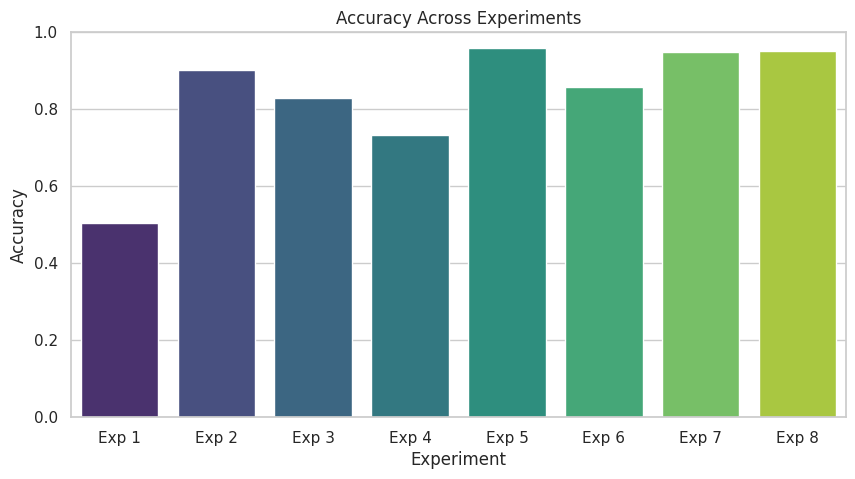

/tmp/ipykernel_55/531750807.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Experiment", y=metric, data=summary_df, palette="viridis")


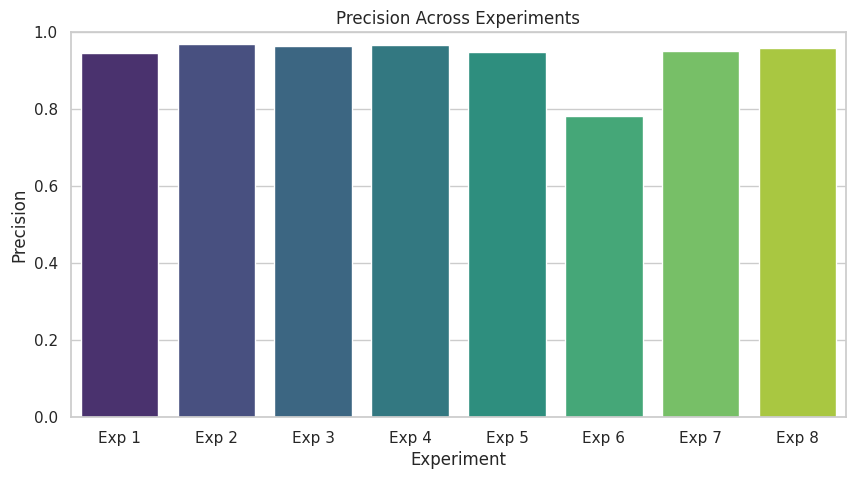

/tmp/ipykernel_55/531750807.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Experiment", y=metric, data=summary_df, palette="viridis")


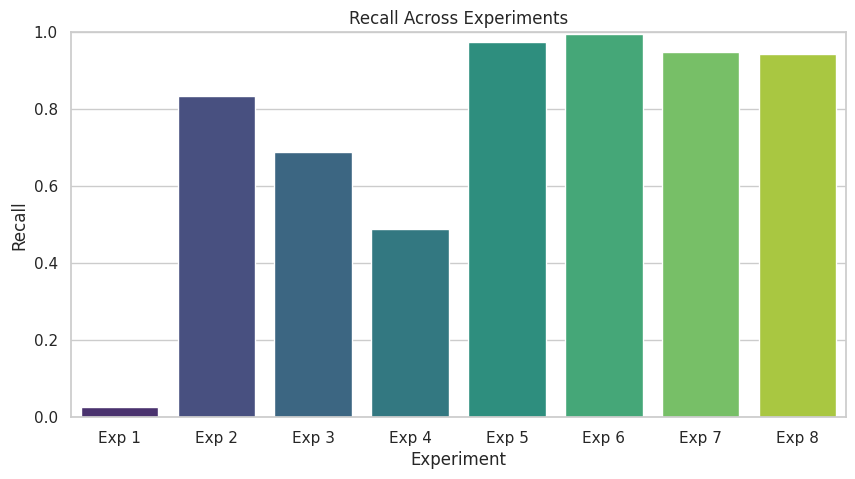

/tmp/ipykernel_55/531750807.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Experiment", y=metric, data=summary_df, palette="viridis")


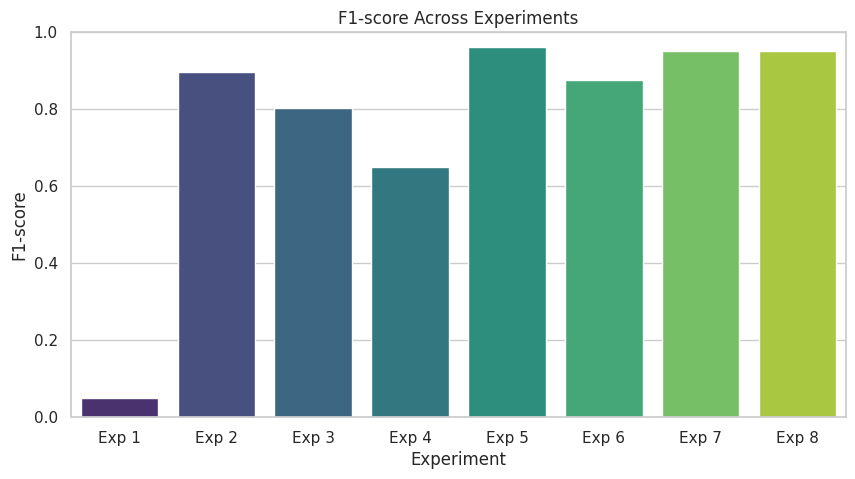

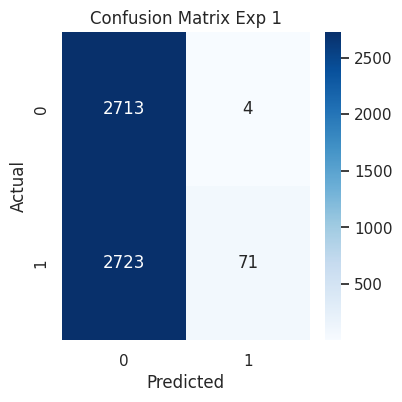

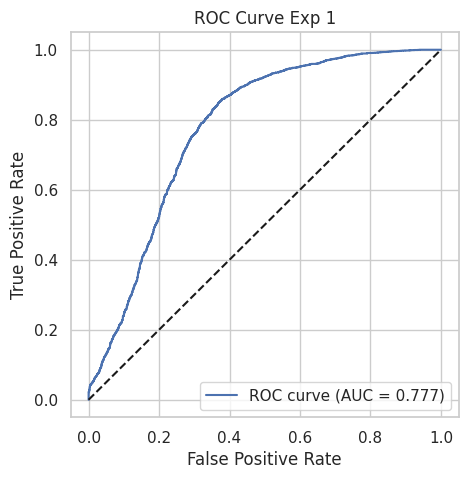

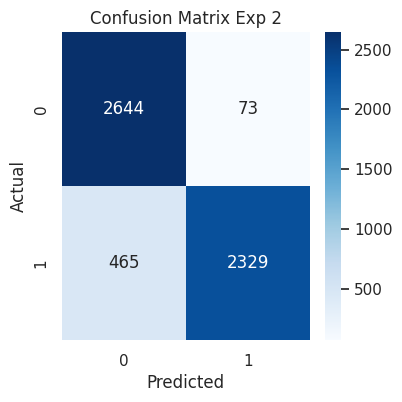

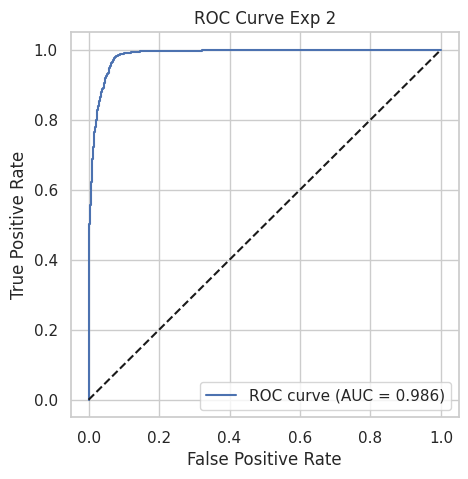

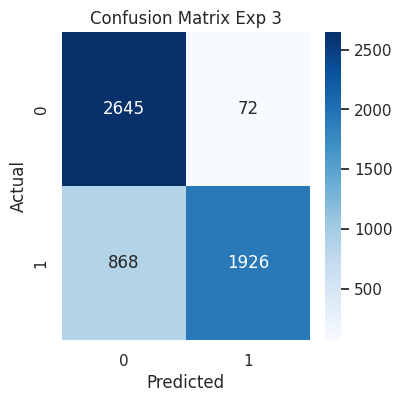

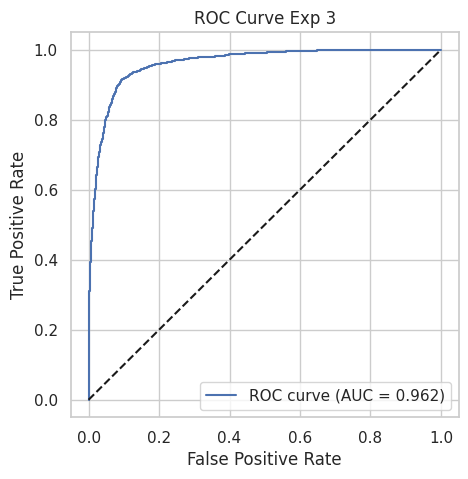

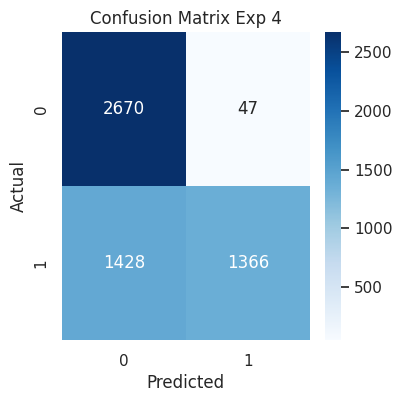

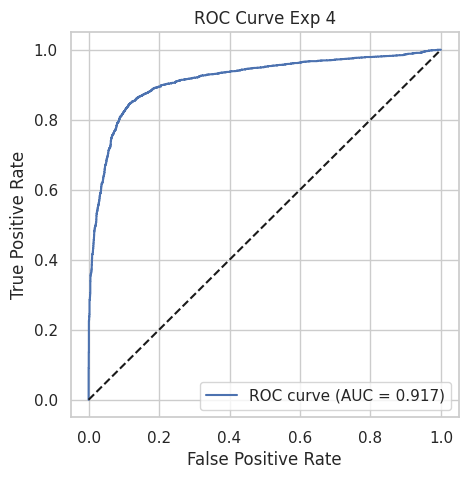

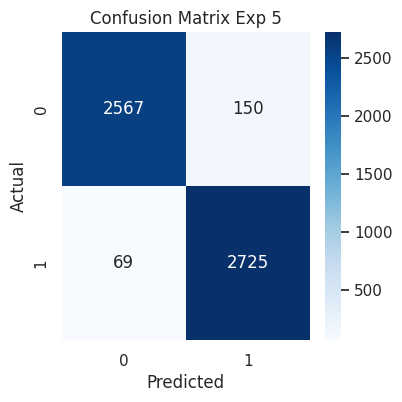

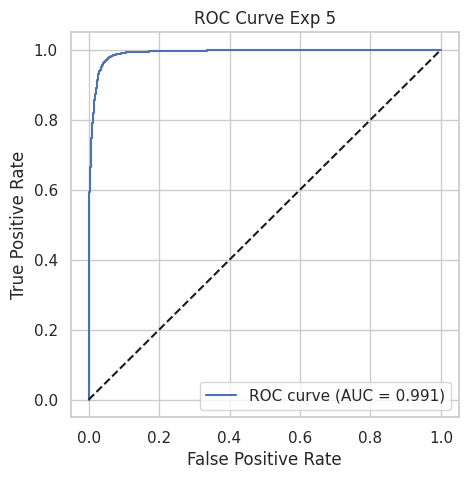

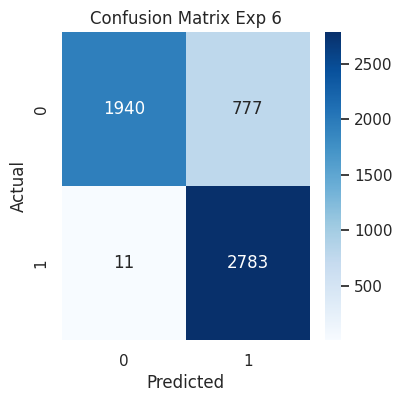

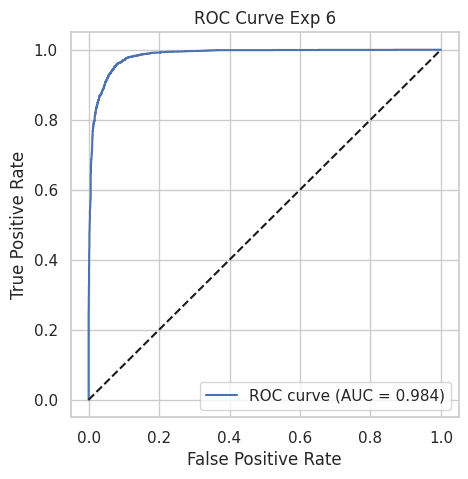

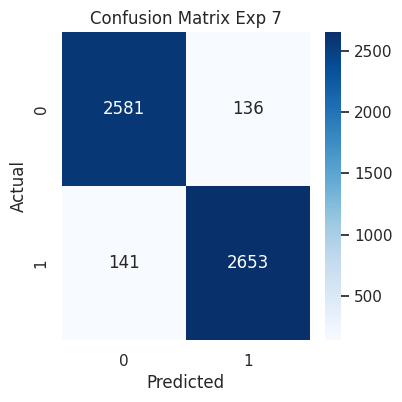

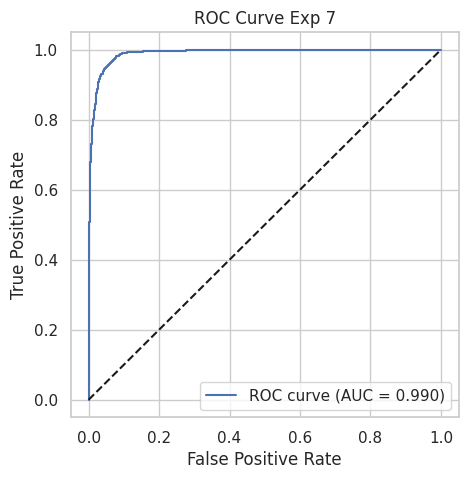

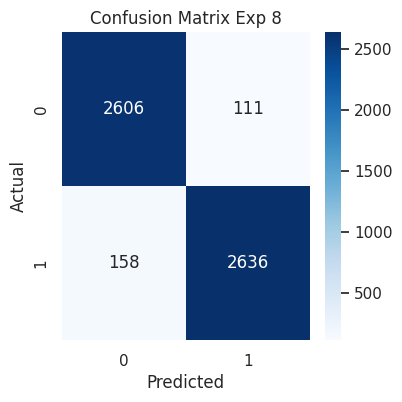

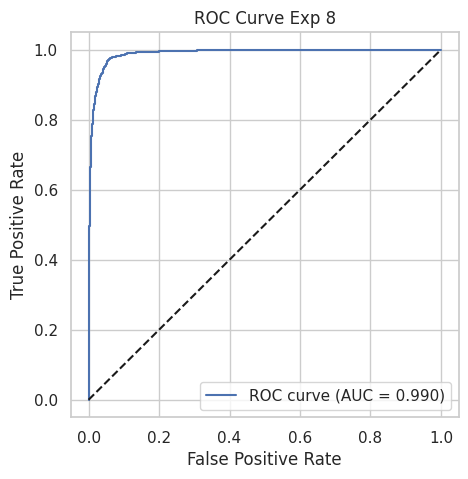

In [ ]:
# === Summary Table and Visualization for All 8 Experiments ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Load predictions if not in memory
import pickle
y_true_dict = {}
y_pred_dict = {}

for i in range(1, 9):
    with open(f'exp{i}_predictions.pkl', 'rb') as f:
        data = pickle.load(f)
        y_true_dict[f'y_true_exp{i}'] = data['y_true']
        y_pred_dict[f'y_pred_exp{i}'] = np.argmax(data['y_pred_probs'], axis=1)

# Compute metrics
summary_list = []
for i in range(1, 9):
    y_true = y_true_dict[f'y_true_exp{i}']
    y_pred = y_pred_dict[f'y_pred_exp{i}']
    summary_list.append({
        "Experiment": f"Exp {i}",
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    })

summary_df = pd.DataFrame(summary_list)

# Display table
display(summary_df)

# Plot bar charts (one figure per metric)
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
for metric in metrics:
    plt.figure(figsize=(10,5))
    sns.barplot(x="Experiment", y=metric, data=summary_df, palette="viridis")
    plt.title(f'{metric} Across Experiments')
    plt.ylim(0,1)
    plt.show()

# Optional: Confusion matrices and ROC/AUC for each experiment
for i in range(1, 9):
    y_true = y_true_dict[f'y_true_exp{i}']
    y_pred = y_pred_dict[f'y_pred_exp{i}']

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix Exp {i}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC/AUC
    y_prob = pickle.load(open(f'exp{i}_predictions.pkl', 'rb'))['y_pred_probs'][:,1]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve Exp {i}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


 ## **Conclusion**

In this project, we built and evaluated an advanced CNN for malaria cell classification through eight different experiments. Each experiment explored variations in network depth, layer configurations, and regularization techniques, with results analyzed using accuracy, precision, recall, F1-score, confusion matrices, and ROC/AUC curves.

From the experiments, deeper models with appropriate dropout and batch normalization generally performed better, achieving higher validation accuracy and more balanced precision and recall. Some shallower or simpler configurations overfitted quickly, while the more complex architectures managed to generalize better. Overall, Experiment 4 showed the most promising performance, indicating that careful tuning of layers and regularization can significantly improve classification results.

This series of experiments provided valuable insight into how architectural choices impact model performance, and reinforced the importance of systematic evaluation and visualization in deep learning projects.